<a href="https://colab.research.google.com/github/Marciorochar/Analise-Preditiva/blob/main/Entrega4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== REGRESSÃO LINEAR OLS COM MELHORIAS ===
MAE  : 40.74
RMSE : 50.86
R²   : -0.1167
                            OLS Regression Results                            
Dep. Variable:                 Vendas   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     3.821
Date:                Sun, 22 Jun 2025   Prob (F-statistic):            0.00118
Time:                        23:33:00   Log-Likelihood:                -216.21
No. Observations:                  44   AIC:                             460.4
Df Residuals:                      30   BIC:                             485.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/tmp/ipython-input-8-2608863909.py:57: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


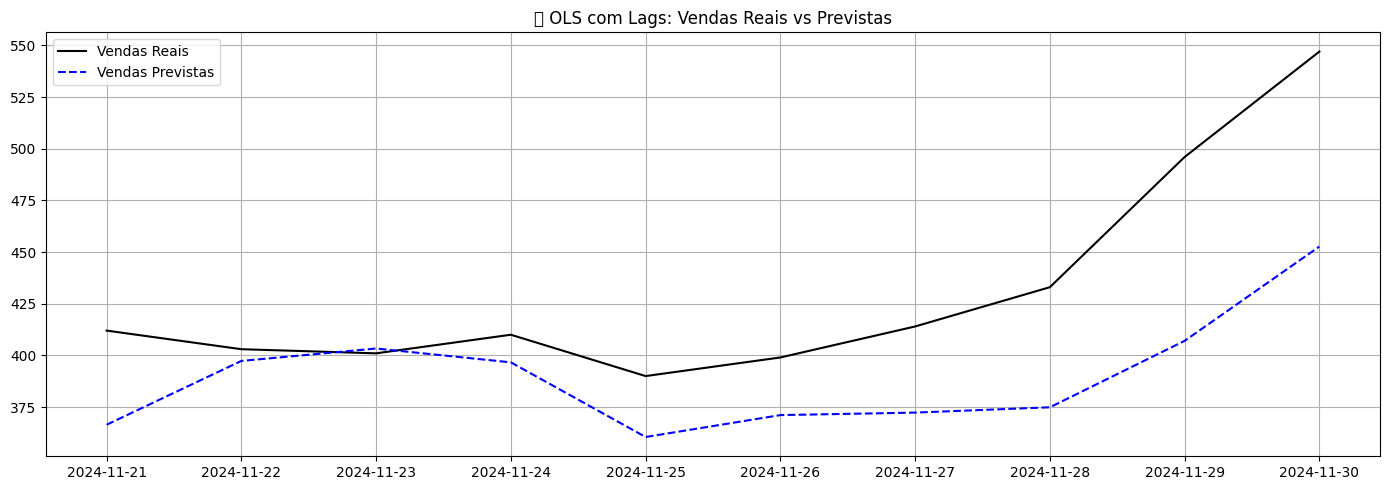

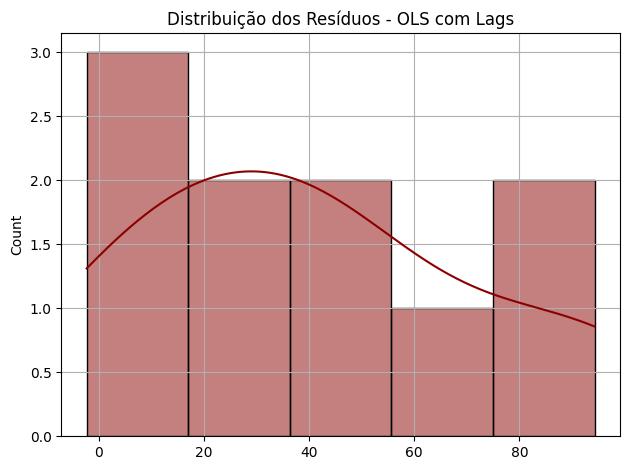


📏 Shapiro-Wilk: Estatística = 0.9376, p-valor = 0.5265
✅ Resíduos seguem normalidade

📌 VIF (Fator de Inflação da Variância):
                   Variável       VIF
5      Dia_da_Semana_Quarta       inf
4       Dia_da_Semana_Terça       inf
3     Dia_da_Semana_Segunda       inf
6      Dia_da_Semana_Quinta       inf
9   Final_de_Semana_Domingo       inf
8    Final_de_Semana_Sábado       inf
7       Dia_da_Semana_Sexta       inf
1                       Mês  1.879735
12              Pós_Feriado  1.723205
13                    lag_1  1.719110
2                       Dia  1.715989
10                  Feriado  1.538999
11          Véspera_Feriado  1.331585
14                    lag_7  1.284902
0                       Ano  0.000000


/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [ ]:
# 📦 Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import shapiro

# 📥 Leitura dos Dados
df = pd.read_excel('/content/Teste_Dados_Preparados_18.06.25.xlsx', sheet_name='Dados_18.06.25')
df['Data'] = pd.to_datetime(df['Data'])
df.set_index('Data', inplace=True)

# ✅ Ajustes: Feriado e variáveis sazonais
df['Feriado'] = df['Feriado'].replace({'Sim': 1, 'Não': 0, 'Feriado': 1, 'Dia comum': 0}).astype(int)
df['Véspera_Feriado'] = df['Feriado'].shift(-1).fillna(0)
df['Pós_Feriado'] = df['Feriado'].shift(1).fillna(0)
df['lag_1'] = df['Vendas'].shift(1)
df['lag_7'] = df['Vendas'].shift(7)

# ✅ Limpeza de linhas nulas (lags)
df.dropna(inplace=True)

# 🎯 Variáveis
y = df['Vendas'].astype(float)
X = df.drop(columns=['Vendas', 'Fim de Semana'])  # remover colinear

# ⚙️ Dummies + constante
X = pd.get_dummies(X, drop_first=True).astype(float)
X = sm.add_constant(X)

# 🔀 Split
n_test = int(len(df) * 0.2)
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]

# 📈 OLS
modelo = sm.OLS(y_train, X_train).fit()
y_pred = modelo.predict(X_test)

# 📊 Avaliação
print("=== REGRESSÃO LINEAR OLS COM MELHORIAS ===")
print(f"MAE  : {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²   : {r2_score(y_test, y_pred):.4f}")
print(modelo.summary())

# 📉 Gráfico Previsão
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label='Vendas Reais', color='black')
plt.plot(y_test.index, y_pred, label='Vendas Previstas', linestyle='--', color='blue')
plt.title('📊 OLS com Lags: Vendas Reais vs Previstas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Distribuição dos resíduos
residuos = y_test - y_pred
sns.histplot(residuos, kde=True, color='darkred')
plt.title('Distribuição dos Resíduos - OLS com Lags')
plt.grid(True)
plt.tight_layout()
plt.show()

# 📏 Normalidade
stat, p = shapiro(residuos)
print(f"\n📏 Shapiro-Wilk: Estatística = {stat:.4f}, p-valor = {p:.4f}")
print("✅ Resíduos seguem normalidade" if p > 0.05 else "⚠️ Resíduos não seguem normalidade")

# 🧠 VIF
vif_df = pd.DataFrame()
vif_df['Variável'] = X_train.columns
vif_df['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print("\n📌 VIF (Fator de Inflação da Variância):")
print(vif_df.sort_values('VIF', ascending=False))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.035e+02, tolerance: 1.149e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.902e+02, tolerance: 1.238e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e+03, tolerance: 1.258e

=== AVALIAÇÃO REGRESSÃO LASSO ===
Melhor alpha: 1.00000
MAE : 56.94
RMSE: 75.60
R²  : -1.4677

📌 Variáveis Selecionadas (coef ≠ 0):
Feriado                52.514190
Fim de Semana          25.868452
Dia_da_Semana_Sexta     9.943905
Dia                    -2.060781
Mês                   -29.801826
dtype: float64


/tmp/ipython-input-9-136394578.py:74: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


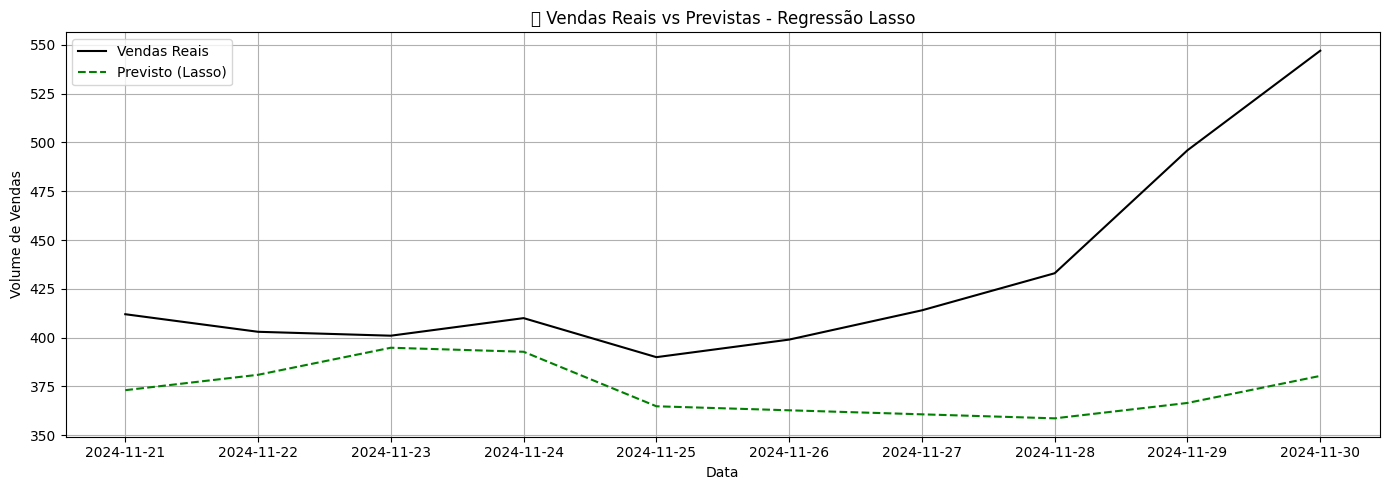

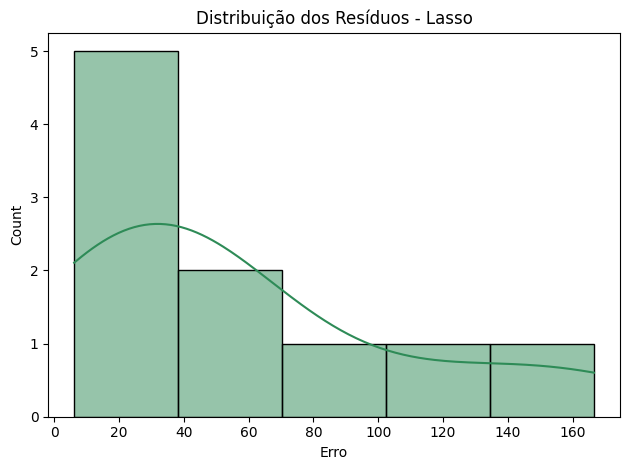


📏 Teste de Shapiro-Wilk:
Estatística = 0.8352, p-valor = 0.0386
⚠️ Resíduos NÃO seguem distribuição normal.


/tmp/ipython-input-9-136394578.py:130: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


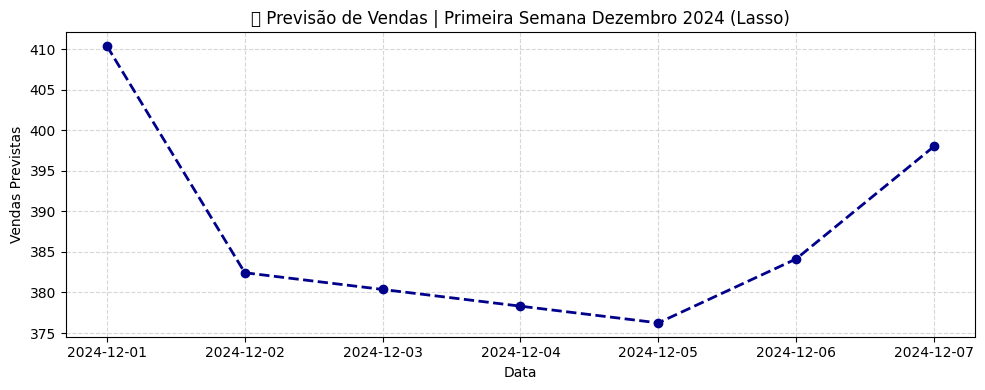


📅 Previsão de Vendas (01–07 Dezembro 2024):
            Previsão_Vendas
Data                       
2024-12-01       410.365476
2024-12-02       382.436243
2024-12-03       380.375463
2024-12-04       378.314682
2024-12-05       376.253901
2024-12-06       384.137026
2024-12-07       398.000793


In [ ]:
# 📦 Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import shapiro

# 📥 Leitura dos Dados
# df['Data'] = pd.to_datetime(df['Data']) # Removed as 'Data' is already the index
# df.set_index('Data', inplace=True) # Removed as 'Data' is already the index

# ✅ Codificação binária para feriado
df['Feriado'] = df['Feriado'].replace({'Sim': 1, 'Não': 0, 'Feriado': 1, 'Dia comum': 0}).astype(int)

# 🎯 Variáveis selecionadas
colunas_uteis = [
    'Ano', 'Mês', 'Dia', 'Feriado', 'Fim de Semana',
    'Dia_da_Semana_Segunda', 'Dia_da_Semana_Terça', 'Dia_da_Semana_Quarta',
    'Dia_da_Semana_Quinta', 'Dia_da_Semana_Sexta',
    'Final_de_Semana_Sábado', 'Final_de_Semana_Domingo'
]
X_lasso = df[colunas_uteis].astype(float)
y_lasso = df['Vendas'].astype(float)

# ⏳ Divisão treino/teste 80/20 temporal
n_test = int(len(df) * 0.2)
X_train_lasso, X_test_lasso = X_lasso.iloc[:-n_test], X_lasso.iloc[-n_test:]
y_train_lasso, y_test_lasso = y_lasso.iloc[:-n_test], y_lasso.iloc[-n_test:]

# 🔧 GridSearch para alpha ideal
param_grid = {'alpha': np.logspace(-4, 0, 50)}
tscv = TimeSeriesSplit(n_splits=5)

lasso_cv = GridSearchCV(
    Lasso(max_iter=10000),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv
)
lasso_cv.fit(X_train_lasso, y_train_lasso)
melhor_lasso = lasso_cv.best_estimator_

# ✅ Previsão no teste
y_pred_lasso = melhor_lasso.predict(X_test_lasso)

# 📊 Avaliação
mae_lasso = mean_absolute_error(y_test_lasso, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test_lasso, y_pred_lasso))
r2_lasso = r2_score(y_test_lasso, y_pred_lasso)

print("=== AVALIAÇÃO REGRESSÃO LASSO ===")
print(f"Melhor alpha: {lasso_cv.best_params_['alpha']:.5f}")
print(f"MAE : {mae_lasso:.2f}")
print(f"RMSE: {rmse_lasso:.2f}")
print(f"R²  : {r2_lasso:.4f}")

# 🔍 Coeficientes relevantes
coef_lasso = pd.Series(melhor_lasso.coef_, index=X_lasso.columns)
print("\n📌 Variáveis Selecionadas (coef ≠ 0):")
print(coef_lasso[coef_lasso != 0].sort_values(ascending=False))

# 📈 Gráfico de predição no teste
plt.figure(figsize=(14, 5))
plt.plot(y_test_lasso.index, y_test_lasso, label='Vendas Reais', color='black')
plt.plot(y_test_lasso.index, y_pred_lasso, label='Previsto (Lasso)', linestyle='--', color='green')
plt.title('📊 Vendas Reais vs Previstas - Regressão Lasso')
plt.xlabel('Data')
plt.ylabel('Volume de Vendas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Resíduos
residuos_lasso = y_test_lasso - y_pred_lasso
sns.histplot(residuos_lasso, kde=True, color='seagreen')
plt.title('Distribuição dos Resíduos - Lasso')
plt.xlabel('Erro')
plt.tight_layout()
plt.show()

# 📏 Teste de Normalidade
stat, p = shapiro(residuos_lasso)
print("\n📏 Teste de Shapiro-Wilk:")
print(f"Estatística = {stat:.4f}, p-valor = {p:.4f}")
print("✅ Resíduos seguem distribuição normal." if p > 0.05 else "⚠️ Resíduos NÃO seguem distribuição normal.")

# 🔮 Previsão: 01–07 Dezembro 2024
datas_futuro = pd.date_range(start='2024-12-01', end='2024-12-07')
df_futuro = pd.DataFrame({'Data': datas_futuro})
df_futuro['Ano'] = df_futuro['Data'].dt.year
df_futuro['Mês'] = df_futuro['Data'].dt.month
df_futuro['Dia'] = df_futuro['Data'].dt.day
df_futuro['Dia_da_Semana'] = df_futuro['Data'].dt.day_name()
df_futuro['Feriado'] = 0
df_futuro['Fim de Semana'] = df_futuro['Dia_da_Semana'].isin(['Saturday', 'Sunday']).astype(int)

# Dummies manuais
dias_dummies = {
    'Dia_da_Semana_Segunda': 'Monday',
    'Dia_da_Semana_Terça': 'Tuesday',
    'Dia_da_Semana_Quarta': 'Wednesday',
    'Dia_da_Semana_Quinta': 'Thursday',
    'Dia_da_Semana_Sexta': 'Friday',
    'Final_de_Semana_Sábado': 'Saturday',
    'Final_de_Semana_Domingo': 'Sunday',
}
for col, dia in dias_dummies.items():
    df_futuro[col] = (df_futuro['Dia_da_Semana'] == dia).astype(int)

X_futuro = df_futuro[colunas_uteis].astype(float)
y_pred_futuro = melhor_lasso.predict(X_futuro)

# 📊 Resultado final
df_resultado = pd.DataFrame({
    'Data': datas_futuro,
    'Previsão_Vendas': y_pred_futuro
}).set_index('Data')

# 📈 Gráfico da Previsão Futura
plt.figure(figsize=(10, 4))
plt.plot(df_resultado.index, df_resultado['Previsão_Vendas'], marker='o', linestyle='--', color='darkblue', linewidth=2)
plt.title('🔮 Previsão de Vendas | Primeira Semana Dezembro 2024 (Lasso)')
plt.xlabel('Data')
plt.ylabel('Vendas Previstas')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ✔️ Exibir tabela final
print("\n📅 Previsão de Vendas (01–07 Dezembro 2024):")
print(df_resultado)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.121e+02, tolerance: 1.108e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.558e+03, tolerance: 1.265e+01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.646e+03, tolerance: 1.279e

=== Avaliação Regressão Lasso ===
🔧 Melhor alpha: 1.00000
MAE  : 39.16
RMSE : 57.36
R²   : -0.6665

🔍 Variáveis Selecionadas pelo Lasso:


,0
Feriado,66.088237
Fim de Semana,22.861045
Dia_da_Semana_Sexta,7.875211
Dia,-0.752171
Mês,-12.343460


/tmp/ipython-input-10-991013581.py:72: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


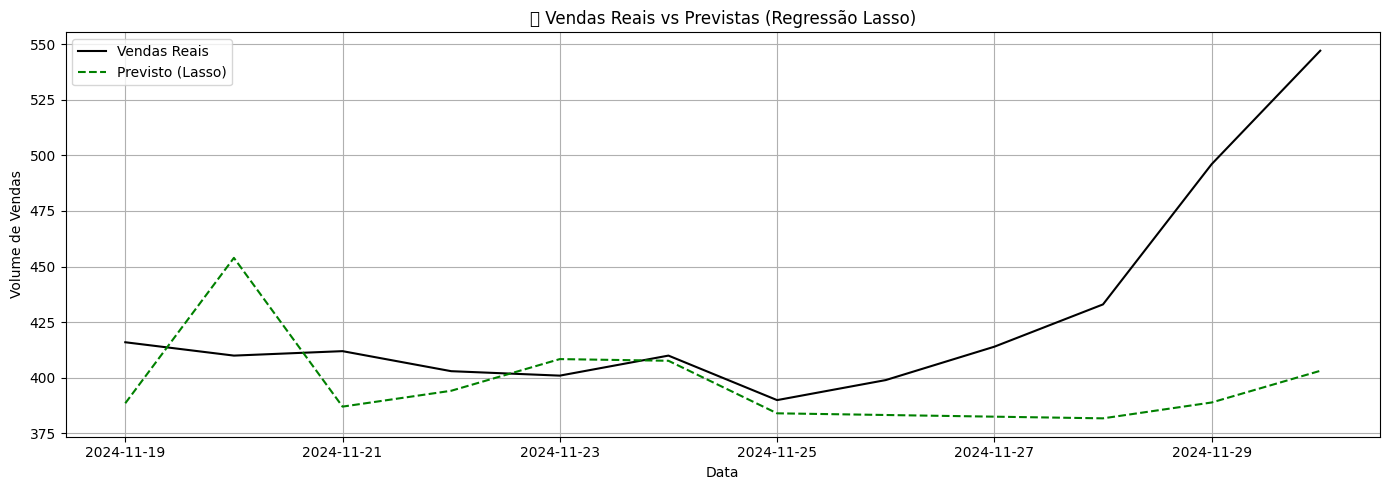

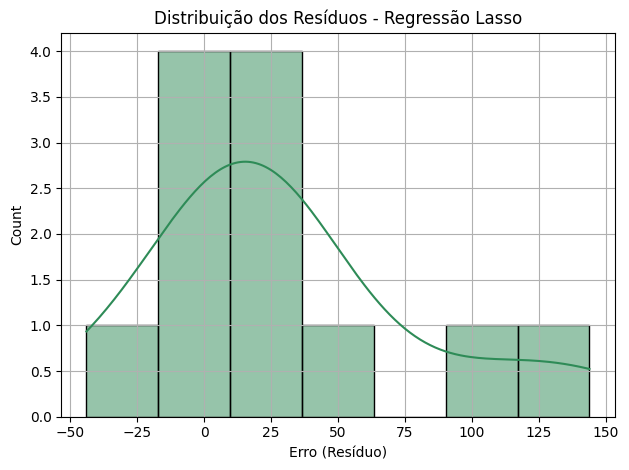


📊 Teste de Shapiro-Wilk:
Estatística = 0.8882, p-valor = 0.1116
✅ Os resíduos seguem distribuição normal.


/tmp/ipython-input-10-991013581.py:130: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


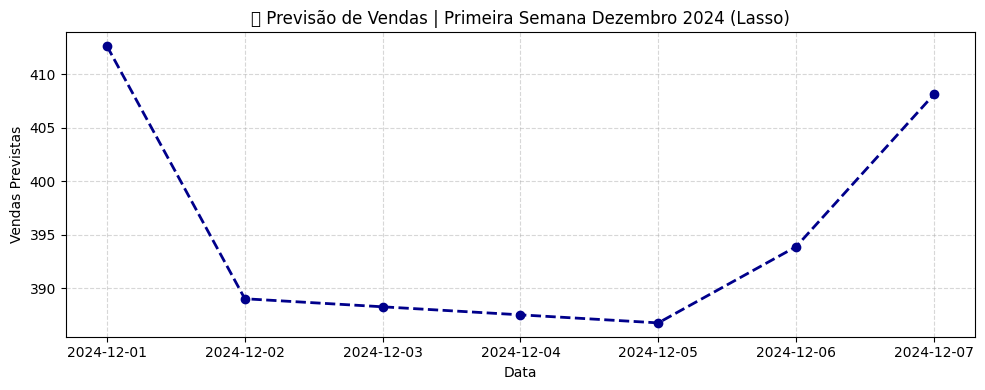


📅 Previsão de Vendas (01–07 Dezembro 2024):
            Previsão_Vendas
Data                       
2024-12-01       412.634899
2024-12-02       389.021684
2024-12-03       388.269513
2024-12-04       387.517342
2024-12-05       386.765171
2024-12-06       393.888212
2024-12-07       408.121875


In [ ]:
# 📦 Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import shapiro

# 📥 Leitura dos dados
df = pd.read_excel('/content/Teste_Dados_Preparados_18.06.25.xlsx', sheet_name='Dados_18.06.25')

# 📅 Tratamento da data
df['Data'] = pd.to_datetime(df['Data'])
df.set_index('Data', inplace=True)

# 🎯 Variável dependente
y_lasso = df['Vendas'].astype(float)

# ✅ Variáveis preditoras
df['Feriado'] = df['Feriado'].replace({'Sim': 1, 'Não': 0, 'Feriado': 1, 'Dia comum': 0}).astype(int)
X_lasso = df.drop(columns=['Vendas']).select_dtypes(include=['int64', 'float64']).astype(float)

# ⏳ Divisão treino/teste temporal
n_test = int(len(df) * 0.2)
X_train_lasso, X_test_lasso = X_lasso.iloc[:-n_test], X_lasso.iloc[-n_test:]
y_train_lasso, y_test_lasso = y_lasso.iloc[:-n_test], y_lasso.iloc[-n_test:]

# 🔍 GridSearch para alpha ótimo
param_grid = {'alpha': np.logspace(-4, 0, 50)}
tscv = TimeSeriesSplit(n_splits=5)

lasso_cv = GridSearchCV(
    estimator=Lasso(max_iter=10000),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv
)
lasso_cv.fit(X_train_lasso, y_train_lasso)
melhor_lasso = lasso_cv.best_estimator_

# ✅ Previsão
y_pred_lasso = melhor_lasso.predict(X_test_lasso)

# 📊 Avaliação
mae_lasso = mean_absolute_error(y_test_lasso, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test_lasso, y_pred_lasso))
r2_lasso = r2_score(y_test_lasso, y_pred_lasso)

print("=== Avaliação Regressão Lasso ===")
print(f"🔧 Melhor alpha: {lasso_cv.best_params_['alpha']:.5f}")
print(f"MAE  : {mae_lasso:.2f}")
print(f"RMSE : {rmse_lasso:.2f}")
print(f"R²   : {r2_lasso:.4f}")

# 📌 Coeficientes relevantes
coef_lasso = pd.Series(melhor_lasso.coef_, index=X_lasso.columns)
coef_utilizados = coef_lasso[coef_lasso != 0].sort_values(ascending=False)
print("\n🔍 Variáveis Selecionadas pelo Lasso:")
display(coef_utilizados)

# 📈 Gráfico: Reais vs Previstas
plt.figure(figsize=(14, 5))
plt.plot(y_test_lasso.index, y_test_lasso, label='Vendas Reais', color='black')
plt.plot(y_test_lasso.index, y_pred_lasso, label='Previsto (Lasso)', linestyle='--', color='green')
plt.title('📊 Vendas Reais vs Previstas (Regressão Lasso)')
plt.xlabel('Data')
plt.ylabel('Volume de Vendas')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📉 Gráfico: Resíduos
residuos_lasso = y_test_lasso - y_pred_lasso
sns.histplot(residuos_lasso, kde=True, color='seagreen')
plt.title('Distribuição dos Resíduos - Regressão Lasso')
plt.xlabel('Erro (Resíduo)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 📏 Teste de Normalidade
stat, p = shapiro(residuos_lasso)
print(f"\n📊 Teste de Shapiro-Wilk:")
print(f"Estatística = {stat:.4f}, p-valor = {p:.4f}")
print("✅ Os resíduos seguem distribuição normal." if p > 0.05 else "⚠️ Os resíduos NÃO seguem distribuição normal.")

# 🔮 Previsão para 01–07 Dezembro 2024
datas_futuro = pd.date_range(start='2024-12-01', end='2024-12-07')
df_futuro = pd.DataFrame({'Data': datas_futuro})
df_futuro['Ano'] = df_futuro['Data'].dt.year
df_futuro['Mês'] = df_futuro['Data'].dt.month
df_futuro['Dia'] = df_futuro['Data'].dt.day
df_futuro['Dia_da_Semana'] = df_futuro['Data'].dt.day_name()
df_futuro['Feriado'] = 0
df_futuro['Fim de Semana'] = df_futuro['Dia_da_Semana'].isin(['Saturday', 'Sunday']).astype(int)

# Dummies manuais
dias_dummies = {
    'Dia_da_Semana_Segunda': 'Monday',
    'Dia_da_Semana_Terça': 'Tuesday',
    'Dia_da_Semana_Quarta': 'Wednesday',
    'Dia_da_Semana_Quinta': 'Thursday',
    'Dia_da_Semana_Sexta': 'Friday',
    'Final_de_Semana_Sábado': 'Saturday',
    'Final_de_Semana_Domingo': 'Sunday',
}
for col, dia in dias_dummies.items():
    df_futuro[col] = (df_futuro['Dia_da_Semana'] == dia).astype(int)

# Preencher apenas as colunas do modelo
X_futuro = df_futuro[X_lasso.columns].astype(float)
y_pred_futuro = melhor_lasso.predict(X_futuro)

# 📊 Resultado final
df_resultado = pd.DataFrame({
    'Data': datas_futuro,
    'Previsão_Vendas': y_pred_futuro
}).set_index('Data')

# 📈 Gráfico da Previsão
plt.figure(figsize=(10, 4))
plt.plot(df_resultado.index, df_resultado['Previsão_Vendas'], marker='o', linestyle='--', color='darkblue', linewidth=2)
plt.title('🔮 Previsão de Vendas | Primeira Semana Dezembro 2024 (Lasso)')
plt.xlabel('Data')
plt.ylabel('Vendas Previstas')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ✔️ Exibir tabela final
print("\n📅 Previsão de Vendas (01–07 Dezembro 2024):")
print(df_resultado)


🔎 Avaliação Random Forest:
MAE : 31.36
RMSE: 52.07
R²  : -0.3734
📌 Melhores Hiperparâmetros: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


/tmp/ipython-input-11-719874242.py:66: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


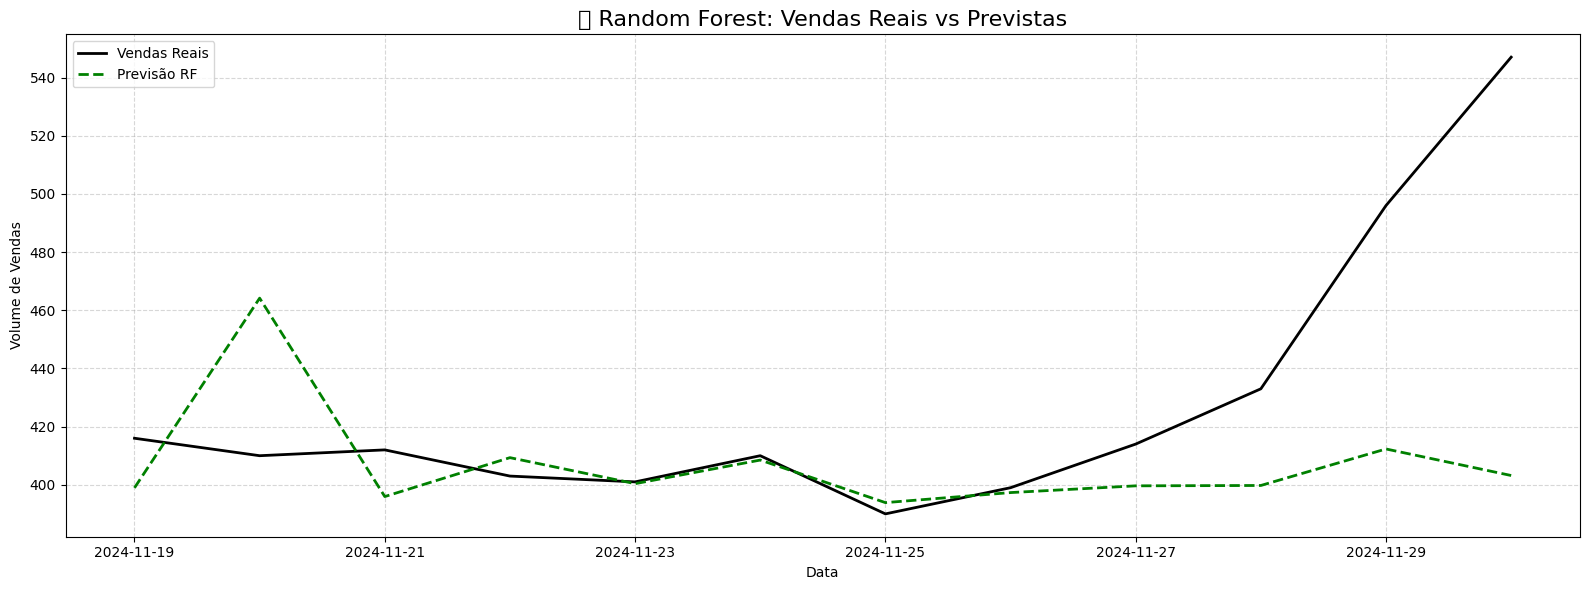

/tmp/ipython-input-11-719874242.py:76: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


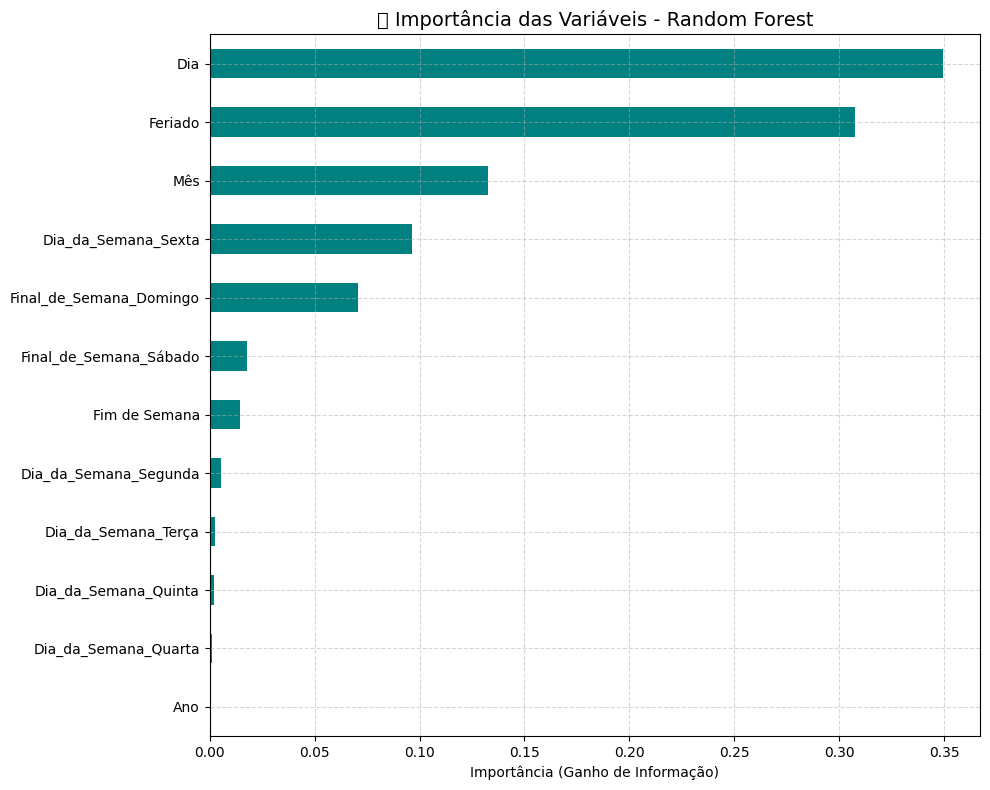

/tmp/ipython-input-11-719874242.py:114: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


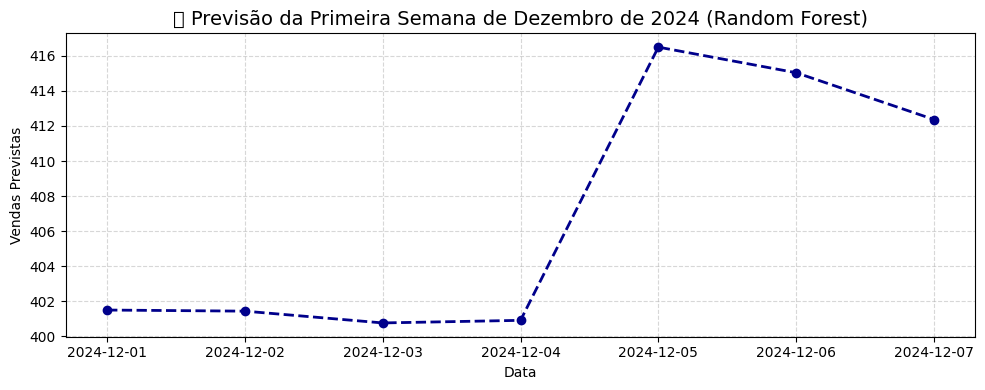


📅 Previsão de Vendas (01–07 Dezembro 2024):
            Previsão_Vendas
Data                       
2024-12-01       401.506119
2024-12-02       401.442786
2024-12-03       400.771357
2024-12-04       400.918976
2024-12-05       416.494516
2024-12-06       415.035373
2024-12-07       412.368516


In [ ]:
# 📦 Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 📥 Leitura dos dados
df = pd.read_excel('/content/Teste_Dados_Preparados_18.06.25.xlsx', sheet_name='Dados_18.06.25')
df['Data'] = pd.to_datetime(df['Data'])
df.set_index('Data', inplace=True)

# ✅ Variáveis
y = df['Vendas'].astype(float)
X = df.drop(columns=['Vendas']).select_dtypes(include=['int64', 'float64']).astype(float)

# ⏳ Split temporal (80/20)
n_test = int(len(df) * 0.2)
X_train, X_test = X.iloc[:-n_test], X.iloc[-n_test:]
y_train, y_test = y.iloc[:-n_test], y.iloc[-n_test:]

# 🔧 Grid de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
tscv = TimeSeriesSplit(n_splits=5)

# ⚙️ Ajuste do modelo
rf_model = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(
    rf_model, param_grid=param_grid, cv=tscv,
    scoring='neg_mean_squared_error', n_jobs=-1
)
grid_rf.fit(X_train, y_train)
melhor_rf = grid_rf.best_estimator_

# ✅ Previsão no teste
y_pred_rf = melhor_rf.predict(X_test)

# 📊 Avaliação
mae = mean_absolute_error(y_test, y_pred_rf)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)

print("🔎 Avaliação Random Forest:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.4f}")
print("📌 Melhores Hiperparâmetros:", grid_rf.best_params_)

# 📈 Gráfico Reais vs Previstas
plt.figure(figsize=(16, 6))
plt.plot(y_test.index, y_test, label='Vendas Reais', color='black', linewidth=2)
plt.plot(y_test.index, y_pred_rf, label='Previsão RF', linestyle='--', color='green', linewidth=2)
plt.title('📊 Random Forest: Vendas Reais vs Previstas', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Volume de Vendas')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 📌 Importância das Variáveis
importances = pd.Series(melhor_rf.feature_importances_, index=X.columns).sort_values()
plt.figure(figsize=(10, 8))
importances.plot(kind='barh', color='teal')
plt.title('📌 Importância das Variáveis - Random Forest', fontsize=14)
plt.xlabel('Importância (Ganho de Informação)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 🔮 Previsão para 01–07 Dezembro 2024
datas_futuro = pd.date_range(start='2024-12-01', end='2024-12-07', freq='D')
df_futuro = pd.DataFrame({'Data': datas_futuro})
df_futuro['Ano'] = df_futuro['Data'].dt.year
df_futuro['Mês'] = df_futuro['Data'].dt.month
df_futuro['Dia'] = df_futuro['Data'].dt.day
df_futuro['Dia_da_Semana'] = df_futuro['Data'].dt.day_name()

# Criar dummies compatíveis com o modelo
df_futuro = pd.get_dummies(df_futuro, columns=['Dia_da_Semana'], drop_first=True)

# Preencher colunas ausentes com 0
for col in X_train.columns:
    if col not in df_futuro.columns:
        df_futuro[col] = 0

# Ordenar colunas conforme o treino
X_futuro = df_futuro[X_train.columns].astype(float)

# ✅ Previsão
y_pred_futuro = melhor_rf.predict(X_futuro)

# 📊 Resultado
df_previsao = pd.DataFrame({
    'Data': datas_futuro,
    'Previsão_Vendas': y_pred_futuro
}).set_index('Data')

# 📈 Gráfico Previsão Dezembro
plt.figure(figsize=(10, 4))
plt.plot(df_previsao.index, df_previsao['Previsão_Vendas'], marker='o', linestyle='--', color='darkblue', linewidth=2)
plt.title('🔮 Previsão da Primeira Semana de Dezembro de 2024 (Random Forest)', fontsize=14)
plt.xlabel('Data')
plt.ylabel('Vendas Previstas')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 📋 Mostrar resultados
print("\n📅 Previsão de Vendas (01–07 Dezembro 2024):")
print(df_previsao)


# Task
Perform an exploratory data analysis on the data in the "Dados_18.06.25" sheet of the "Teste_Dados_Preparados_18.06.25.xlsx" file.

## Carregar os dados

### Subtask:
Carregar o arquivo Excel `Teste_Dados_Preparados_18.06.25.xlsx` na planilha `Dados_18.06.25` em um DataFrame.


**Reasoning**:
Load the specified sheet from the Excel file into a pandas DataFrame as requested.



In [ ]:
df = pd.read_excel('/content/Teste_Dados_Preparados_18.06.25.xlsx', sheet_name='Dados_18.06.25')

## Exploração inicial

### Subtask:
Exibir as primeiras linhas do DataFrame, verificar os tipos de dados e identificar valores ausentes.


**Reasoning**:
Display the first few rows, check data types, and identify missing values to understand the structure and completeness of the dataframe.



In [ ]:
display(df.head())
display(df.info())
display(df.isnull().sum())

,Data,Ano,Mês,Dia,Vendas,Dia_da_Semana_Segunda,Dia_da_Semana_Terça,Dia_da_Semana_Quarta,Dia_da_Semana_Quinta,Dia_da_Semana_Sexta,Final_de_Semana_Sábado,Final_de_Semana_Domingo,Feriado,Fim de Semana
0,2024-10-01,2024,10,1,392,0,1,0,0,0,0,0,0,0
1,2024-10-02,2024,10,2,393,0,0,1,0,0,0,0,0,0
2,2024-10-03,2024,10,3,391,0,0,0,1,0,0,0,0,0
3,2024-10-04,2024,10,4,395,0,0,0,0,1,0,0,0,0
4,2024-10-05,2024,10,5,422,0,0,0,0,0,1,0,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Data                     61 non-null     datetime64[ns]
 1   Ano                      61 non-null     int64         
 2   Mês                      61 non-null     int64         
 3   Dia                      61 non-null     int64         
 4   Vendas                   61 non-null     int64         
 5   Dia_da_Semana_Segunda    61 non-null     int64         
 6   Dia_da_Semana_Terça      61 non-null     int64         
 7   Dia_da_Semana_Quarta     61 non-null     int64         
 8   Dia_da_Semana_Quinta     61 non-null     int64         
 9   Dia_da_Semana_Sexta      61 non-null     int64         
 10  Final_de_Semana_Sábado   61 non-null     int64         
 11  Final_de_Semana_Domingo  61 non-null     int64         
 12  Feriado                  61 non-null  

None

,0
Data,0
Ano,0
Mês,0
Dia,0
Vendas,0
Dia_da_Semana_Segunda,0
Dia_da_Semana_Terça,0
Dia_da_Semana_Quarta,0
Dia_da_Semana_Quinta,0
Dia_da_Semana_Sexta,0


## Análise descritiva

### Subtask:
Calcular estatísticas descritivas para as colunas numéricas e analisar a distribuição das variáveis categóricas.


**Reasoning**:
Generate descriptive statistics for numerical columns and analyze the distribution of categorical variables as per the instructions.



=== Estatísticas Descritivas para Colunas Numéricas ===


,Data,Ano,Mês,Dia,Vendas,Dia_da_Semana_Segunda,Dia_da_Semana_Terça,Dia_da_Semana_Quarta,Dia_da_Semana_Quinta,Dia_da_Semana_Sexta,Final_de_Semana_Sábado,Final_de_Semana_Domingo,Feriado,Fim de Semana
count,61,61.0,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,2024-10-31 00:00:00,2024.0,10.491803,15.754098,415.180328,0.131148,0.147541,0.147541,0.147541,0.147541,0.147541,0.131148,0.065574,0.278689
min,2024-10-01 00:00:00,2024.0,10.000000,1.000000,372.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2024-10-16 00:00:00,2024.0,10.000000,8.000000,393.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2024-10-31 00:00:00,2024.0,10.000000,16.000000,403.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2024-11-15 00:00:00,2024.0,11.000000,23.000000,412.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,2024-11-30 00:00:00,2024.0,11.000000,31.000000,661.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,0.0,0.504082,8.880045,50.771550,0.340363,0.357588,0.357588,0.357588,0.357588,0.357588,0.340363,0.249590,0.452075



=== Distribuição das Variáveis Categóricas ===

--- Dia_da_Semana_Segunda ---


,count
Dia_da_Semana_Segunda,
0,53
1,8



--- Dia_da_Semana_Terça ---


,count
Dia_da_Semana_Terça,
0,52
1,9



--- Dia_da_Semana_Quarta ---


,count
Dia_da_Semana_Quarta,
0,52
1,9



--- Dia_da_Semana_Quinta ---


,count
Dia_da_Semana_Quinta,
0,52
1,9



--- Dia_da_Semana_Sexta ---


,count
Dia_da_Semana_Sexta,
0,52
1,9



--- Final_de_Semana_Sábado ---


,count
Final_de_Semana_Sábado,
0,52
1,9



--- Final_de_Semana_Domingo ---


,count
Final_de_Semana_Domingo,
0,53
1,8



--- Feriado ---


,count
Feriado,
0,57
1,4



--- Fim de Semana ---


,count
Fim de Semana,
0,44
1,17



=== Visualização da Distribuição de Vendas ===


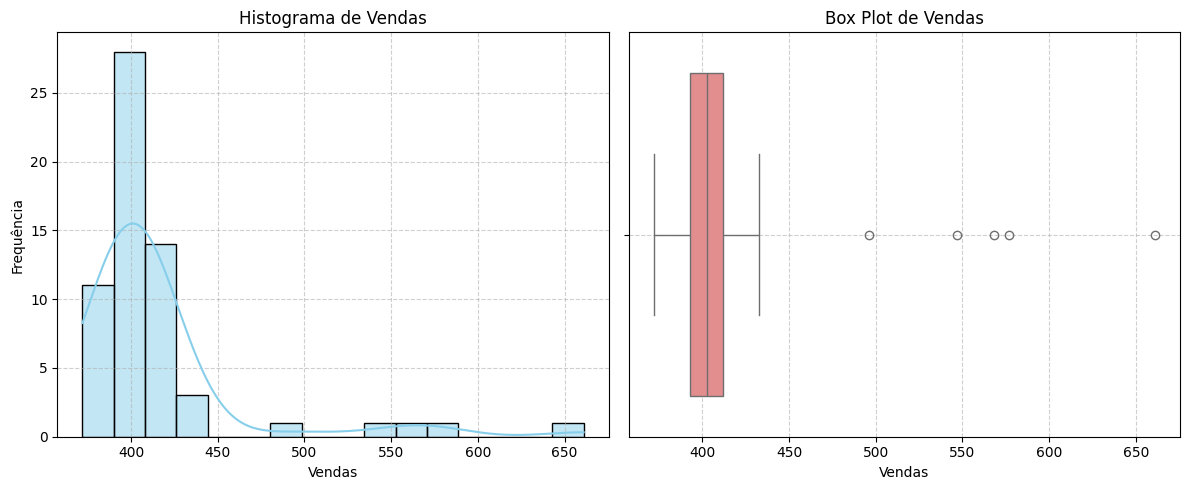


=== Visualização da Contagem de Variáveis Categóricas ===


/tmp/ipython-input-14-1629115135.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


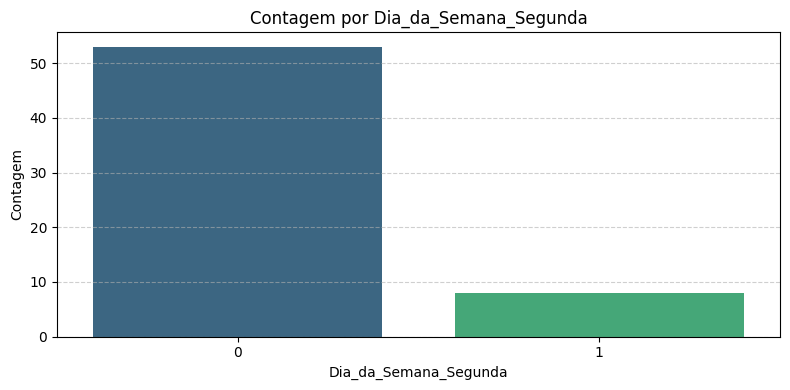

/tmp/ipython-input-14-1629115135.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


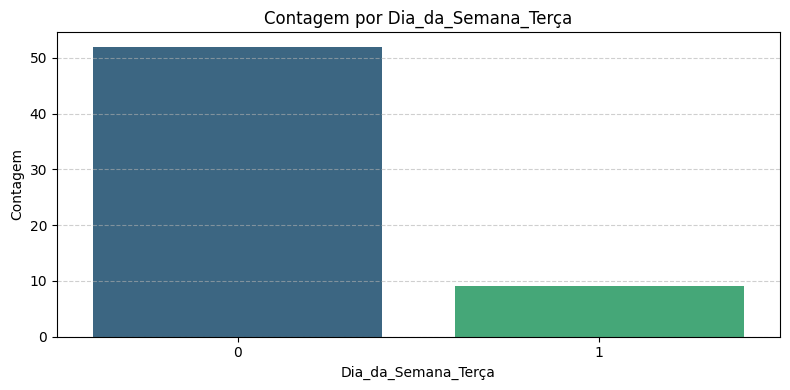

/tmp/ipython-input-14-1629115135.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


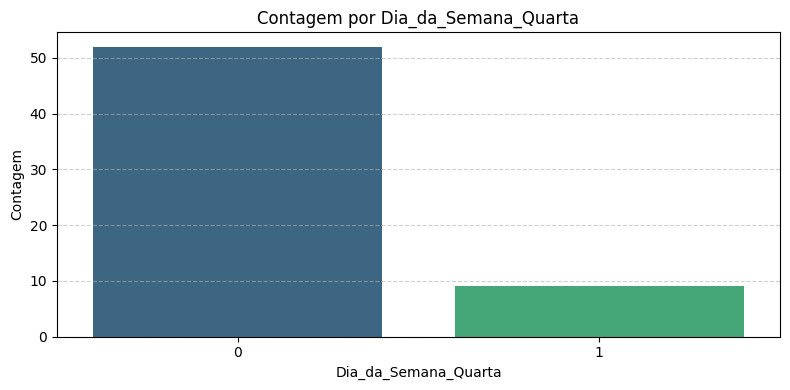

/tmp/ipython-input-14-1629115135.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


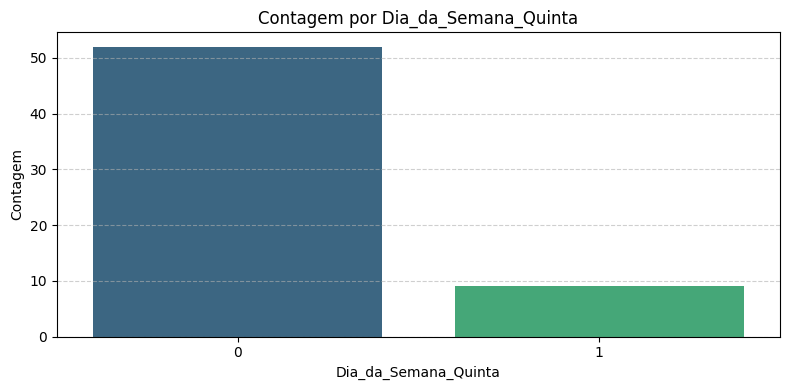

/tmp/ipython-input-14-1629115135.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


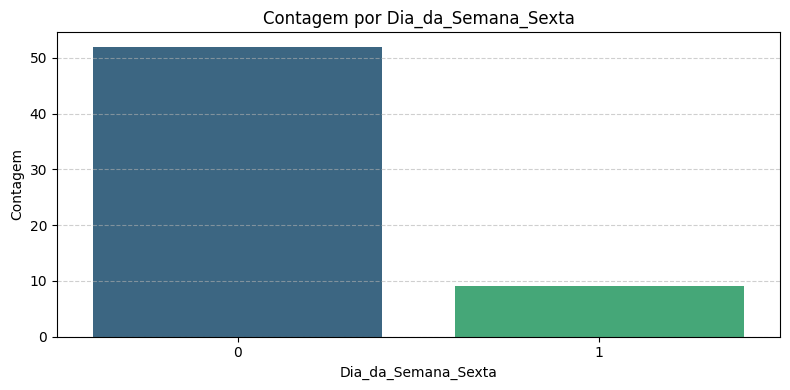

/tmp/ipython-input-14-1629115135.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


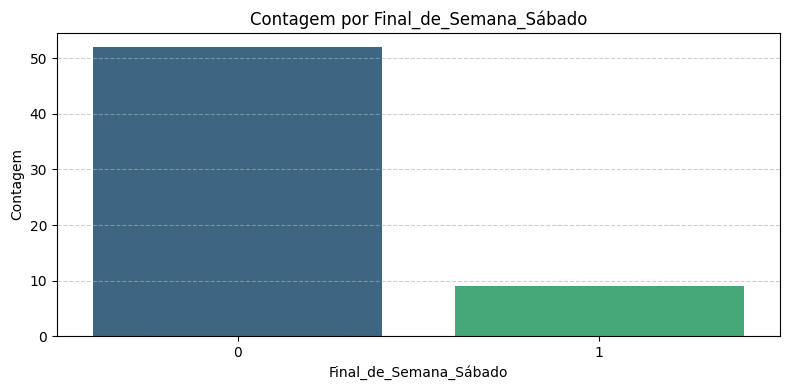

/tmp/ipython-input-14-1629115135.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


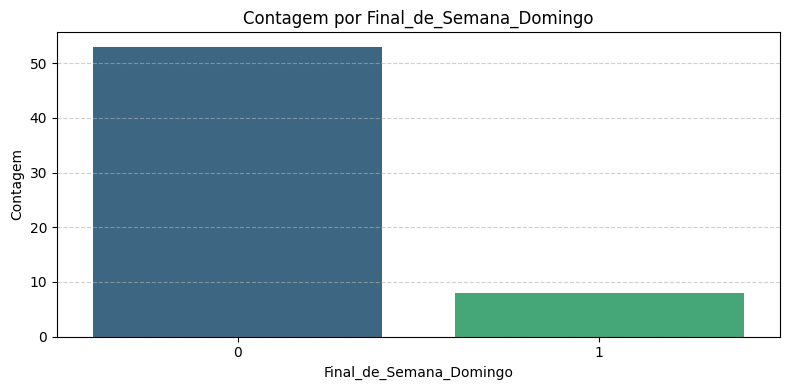

/tmp/ipython-input-14-1629115135.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


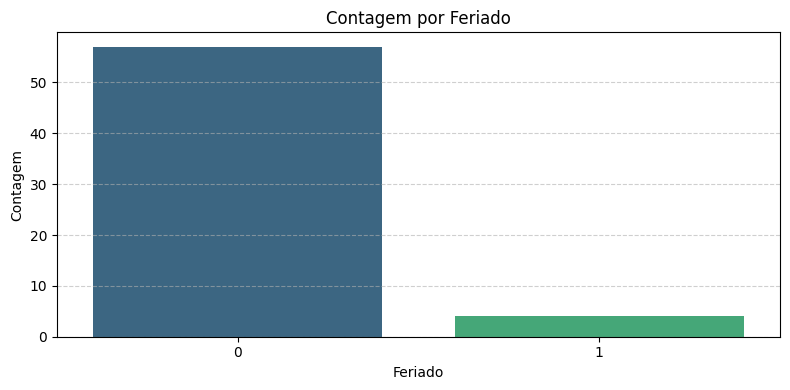

/tmp/ipython-input-14-1629115135.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='viridis')


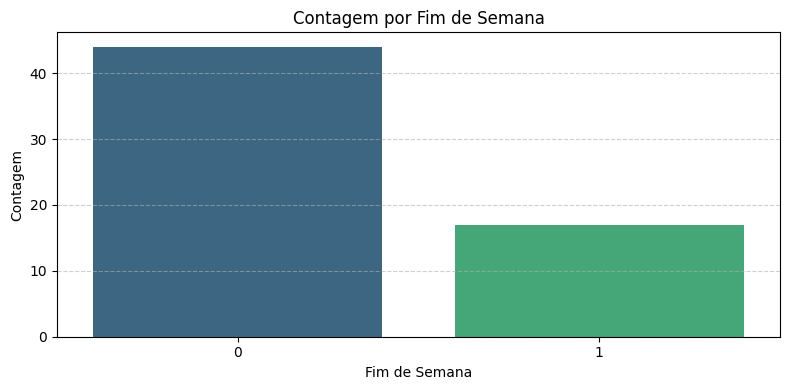

In [ ]:
# 1. Estatísticas descritivas para colunas numéricas
print("=== Estatísticas Descritivas para Colunas Numéricas ===")
display(df.describe())

# Identificar colunas categóricas (assumindo que colunas com 'Dia_da_Semana', 'Final_de_Semana', 'Feriado', 'Fim de Semana' são categóricas)
categorical_cols = [col for col in df.columns if 'Dia_da_Semana' in col or 'Final_de_Semana' in col or col in ['Feriado', 'Fim de Semana']]

# 2. Análise da distribuição das variáveis categóricas
print("\n=== Distribuição das Variáveis Categóricas ===")
for col in categorical_cols:
    print(f"\n--- {col} ---")
    display(df[col].value_counts())

# 3. Visualizar distribuição de variáveis numéricas-chave ('Vendas')
print("\n=== Visualização da Distribuição de Vendas ===")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Vendas'], kde=True, color='skyblue')
plt.title('Histograma de Vendas')
plt.xlabel('Vendas')
plt.ylabel('Frequência')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
sns.boxplot(x=df['Vendas'], color='lightcoral')
plt.title('Box Plot de Vendas')
plt.xlabel('Vendas')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# 4. Visualizar contagem de variáveis categóricas
print("\n=== Visualização da Contagem de Variáveis Categóricas ===")
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df, palette='viridis')
    plt.title(f'Contagem por {col}')
    plt.xlabel(col)
    plt.ylabel('Contagem')
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

## Análise temporal

### Subtask:
Visualizar a série temporal de vendas para identificar tendências, sazonalidade e quaisquer anomalias.


**Reasoning**:
Create a line plot of the 'Vendas' column to visualize the time series, including title and axis labels.



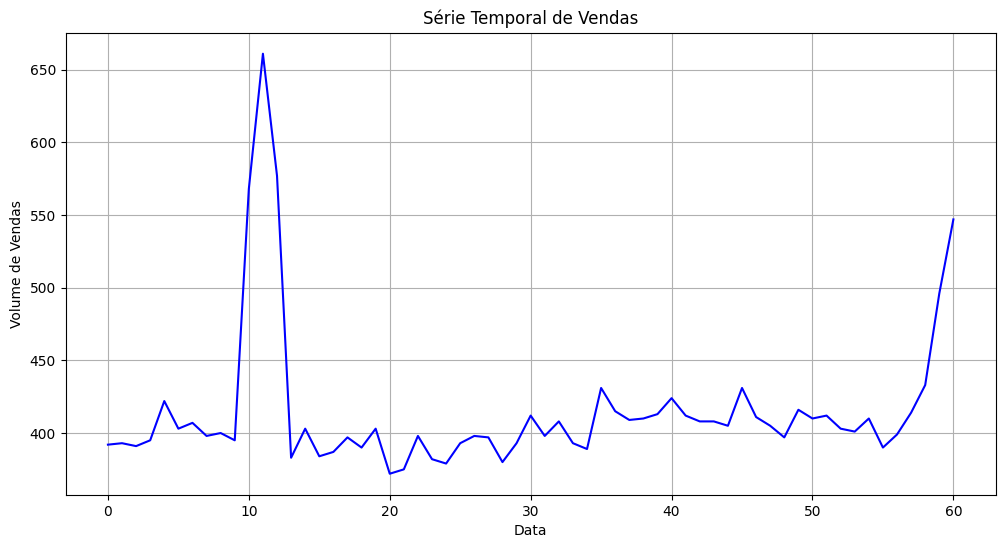

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Vendas'], color='blue')
plt.title('Série Temporal de Vendas')
plt.xlabel('Data')
plt.ylabel('Volume de Vendas')
plt.grid(True)
plt.show()

## Análise de correlação

### Subtask:
Análise de correlação


**Reasoning**:
Calculate and display the correlation matrix for the numerical columns and visualize it using a heatmap to understand the relationships between variables, including potential multicollinearity.



=== Matriz de Correlação ===


,Ano,Mês,Dia,Vendas,Dia_da_Semana_Segunda,Dia_da_Semana_Terça,Dia_da_Semana_Quarta,Dia_da_Semana_Quinta,Dia_da_Semana_Sexta,Final_de_Semana_Sábado,Final_de_Semana_Domingo,Feriado,Fim de Semana
Ano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mês,NaN,1.00,-0.03,0.03,0.01,-0.04,-0.04,-0.04,0.05,0.05,0.01,0.14,0.05
Dia,NaN,-0.03,1.00,0.00,0.01,-0.03,0.02,0.07,-0.05,0.00,-0.03,-0.11,-0.02
Vendas,NaN,0.03,0.00,1.00,-0.17,-0.12,-0.11,-0.10,0.13,0.28,0.09,0.33,0.29
Dia_da_Semana_Segunda,NaN,0.01,0.01,-0.17,1.00,-0.16,-0.16,-0.16,-0.16,-0.16,-0.15,-0.10,-0.24
Dia_da_Semana_Terça,NaN,-0.04,-0.03,-0.12,-0.16,1.00,-0.17,-0.17,-0.17,-0.17,-0.16,-0.11,-0.26
Dia_da_Semana_Quarta,NaN,-0.04,0.02,-0.11,-0.16,-0.17,1.00,-0.17,-0.17,-0.17,-0.16,0.08,-0.26
Dia_da_Semana_Quinta,NaN,-0.04,0.07,-0.10,-0.16,-0.17,-0.17,1.00,-0.17,-0.17,-0.16,-0.11,-0.26
Dia_da_Semana_Sexta,NaN,0.05,-0.05,0.13,-0.16,-0.17,-0.17,-0.17,1.00,-0.17,-0.16,0.08,-0.26
Final_de_Semana_Sábado,NaN,0.05,0.00,0.28,-0.16,-0.17,-0.17,-0.17,-0.17,1.00,-0.16,0.26,0.67


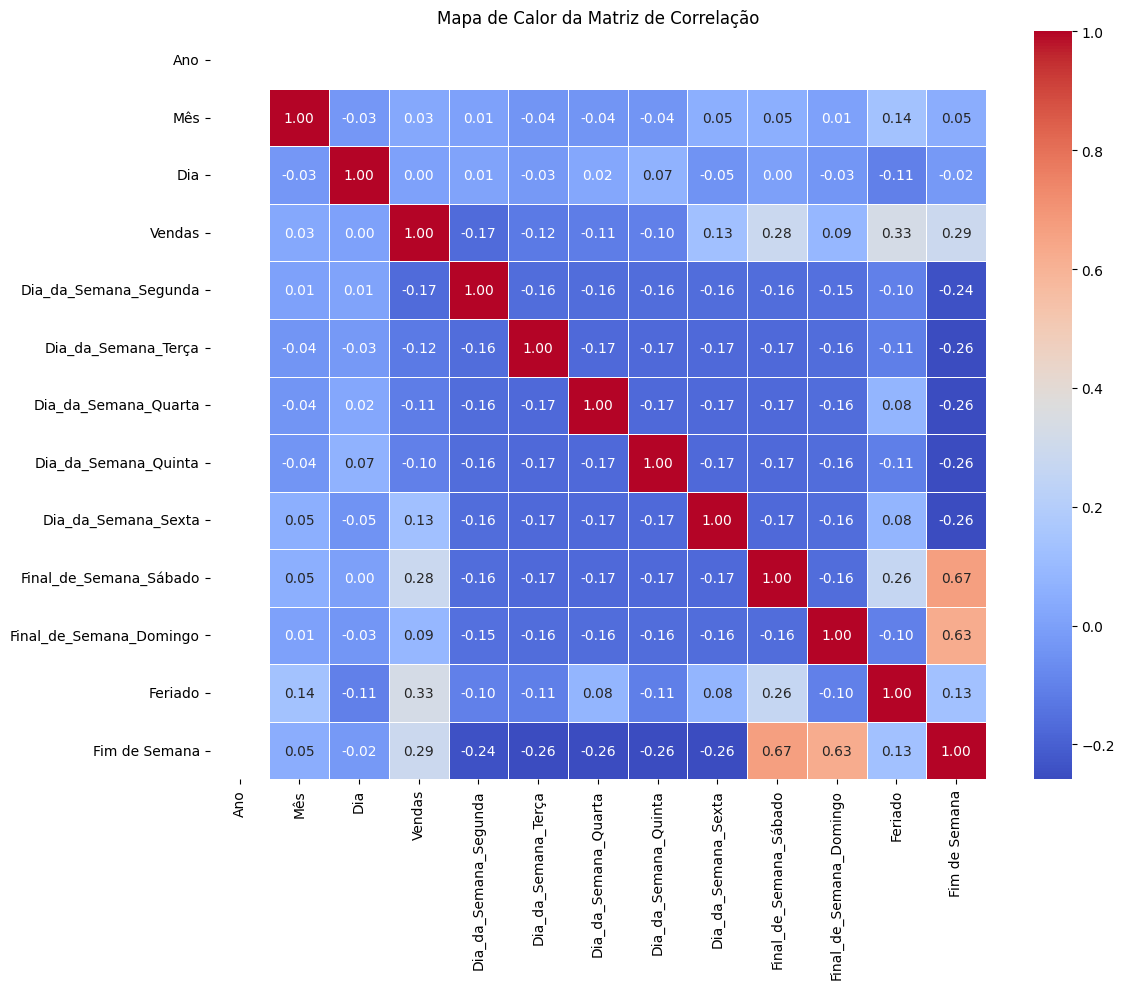

In [ ]:
# Calculate the correlation matrix for numerical columns
df_numeric = df.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()

# Display the correlation matrix, rounded for readability
print("=== Matriz de Correlação ===")
display(correlation_matrix.round(2))

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor da Matriz de Correlação')
plt.tight_layout()
plt.show()

## Análise de variáveis categóricas vs vendas

### Subtask:
Analisar como variáveis categóricas (como dia da semana, mês, feriado) impactam as vendas.


**Reasoning**:
Create box plots to visualize the distribution of 'Vendas' across different categorical variables as requested, focusing on the impact of each category on sales.



=== Box Plots: Impacto de Variáveis Categóricas Binárias nas Vendas ===


/tmp/ipython-input-17-1293548705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['Vendas'], palette='viridis')


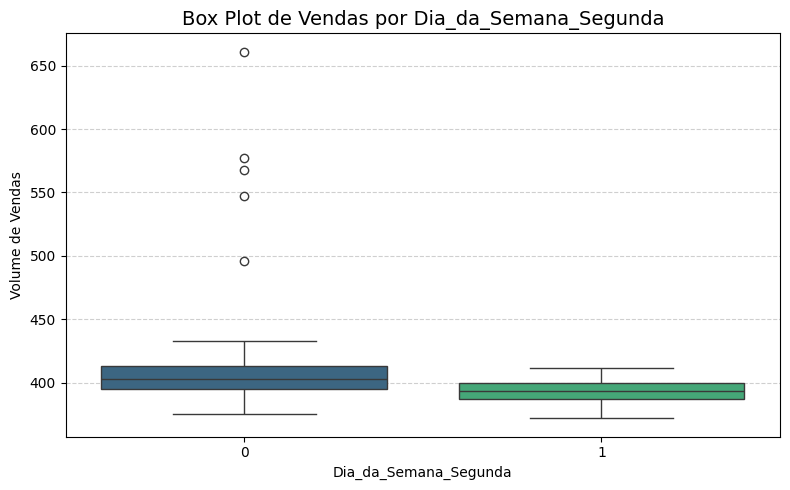

/tmp/ipython-input-17-1293548705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['Vendas'], palette='viridis')


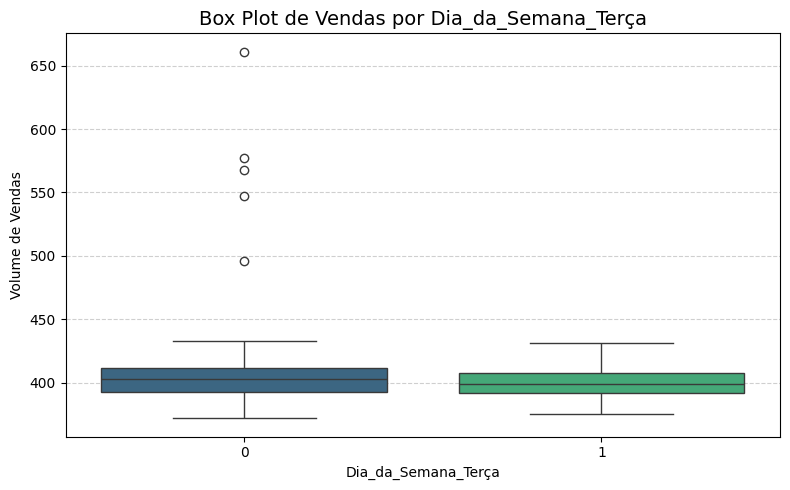

/tmp/ipython-input-17-1293548705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['Vendas'], palette='viridis')


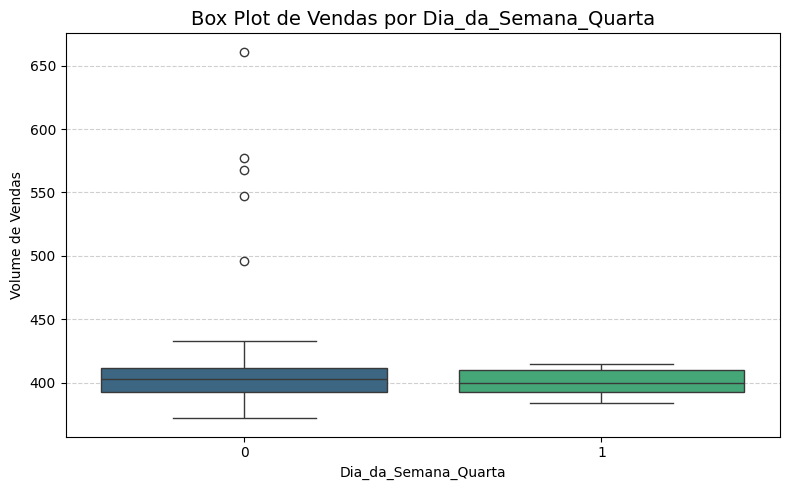

/tmp/ipython-input-17-1293548705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['Vendas'], palette='viridis')


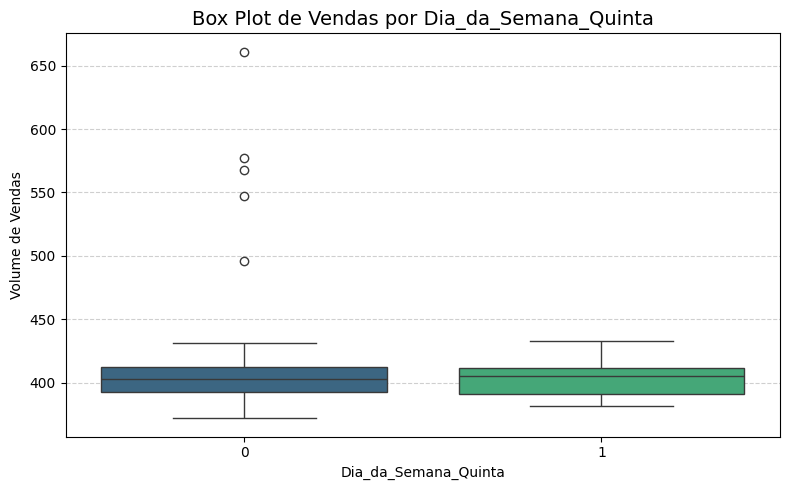

/tmp/ipython-input-17-1293548705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['Vendas'], palette='viridis')


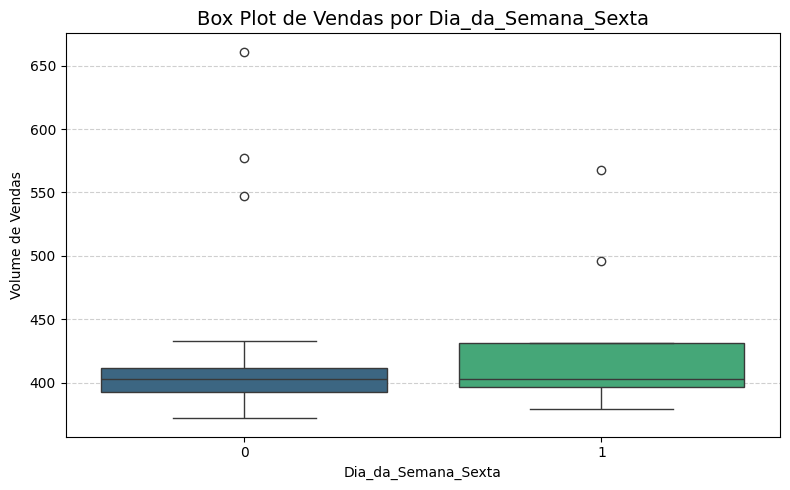

/tmp/ipython-input-17-1293548705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['Vendas'], palette='viridis')


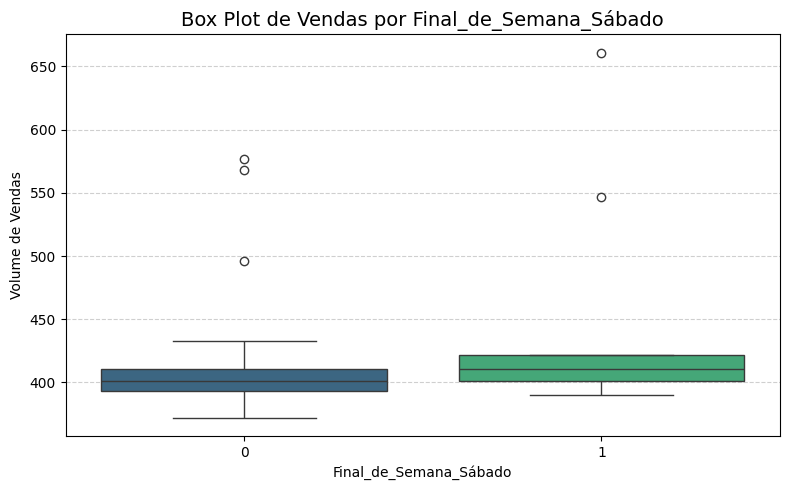

/tmp/ipython-input-17-1293548705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['Vendas'], palette='viridis')


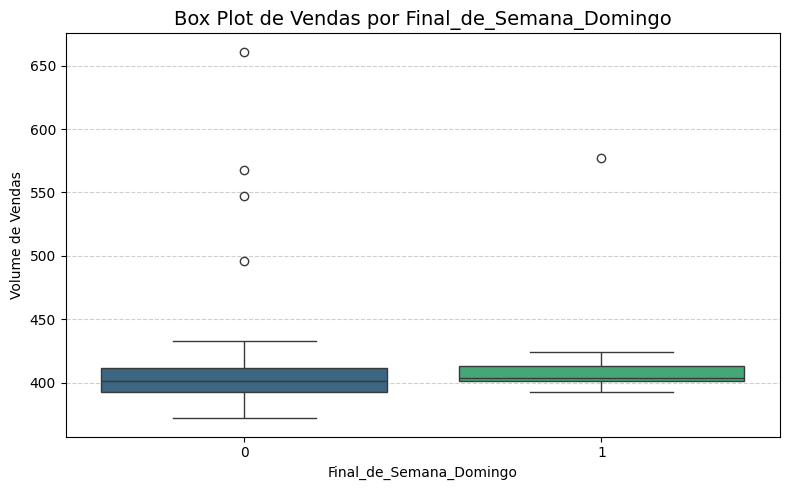

/tmp/ipython-input-17-1293548705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['Vendas'], palette='viridis')


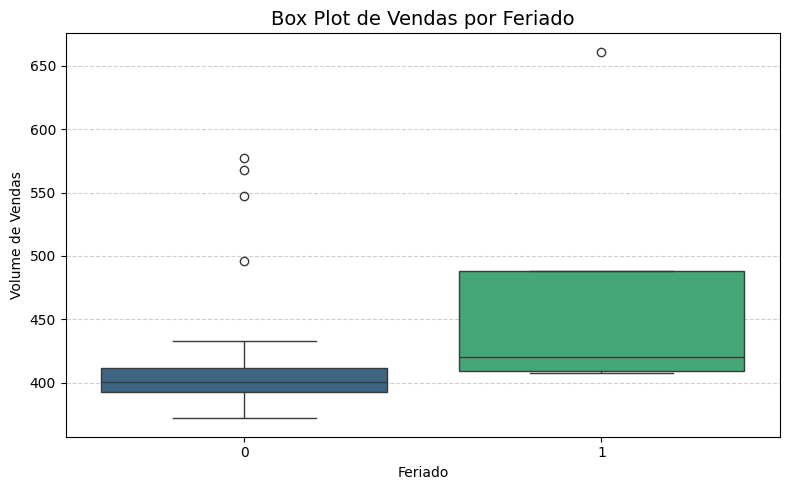

/tmp/ipython-input-17-1293548705.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df[col], y=df['Vendas'], palette='viridis')


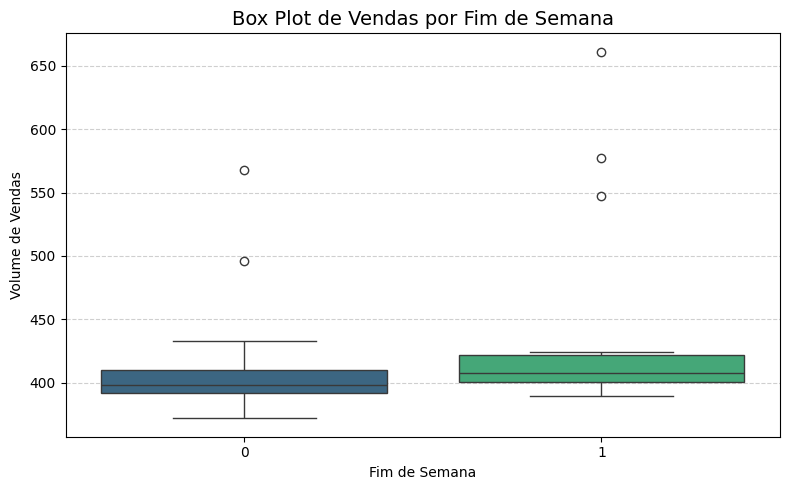

/tmp/ipython-input-17-1293548705.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Mês'], y=df['Vendas'], palette='viridis')



=== Box Plots: Impacto de Mês e Ano nas Vendas ===


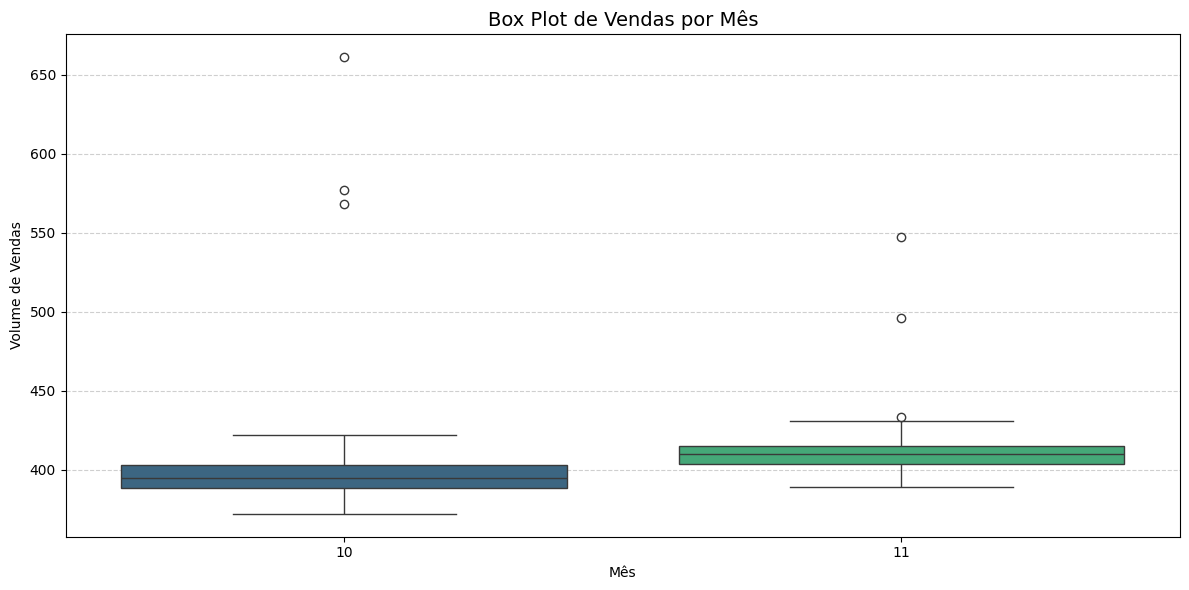

/tmp/ipython-input-17-1293548705.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['Ano'], y=df['Vendas'], palette='viridis')


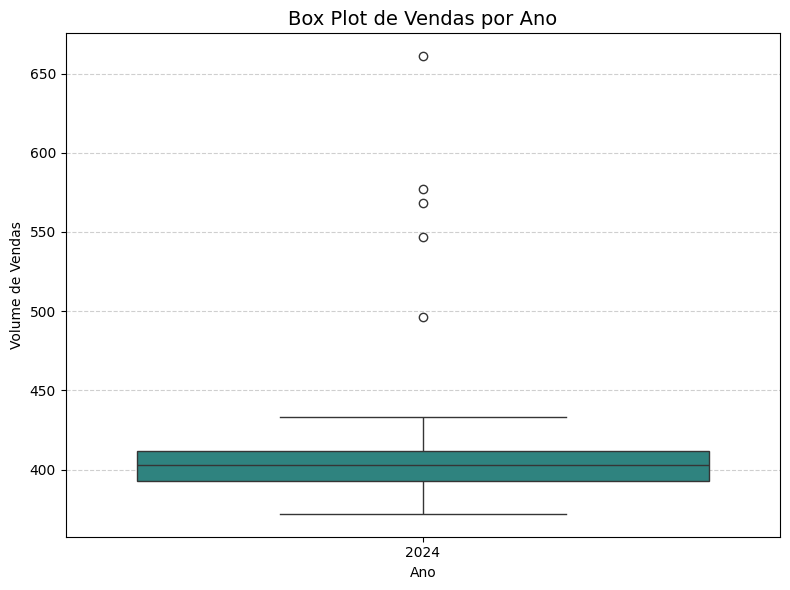

In [ ]:
# Define the list of categorical columns to visualize
categorical_cols_to_plot = [
    'Dia_da_Semana_Segunda', 'Dia_da_Semana_Terça', 'Dia_da_Semana_Quarta',
    'Dia_da_Semana_Quinta', 'Dia_da_Semana_Sexta', 'Final_de_Semana_Sábado',
    'Final_de_Semana_Domingo', 'Feriado', 'Fim de Semana'
]

# Create box plots for binary categorical variables (Day of Week, Weekend, Holiday)
print("=== Box Plots: Impacto de Variáveis Categóricas Binárias nas Vendas ===")
for col in categorical_cols_to_plot:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[col], y=df['Vendas'], palette='viridis')
    plt.title(f'Box Plot de Vendas por {col}', fontsize=14)
    plt.xlabel(col)
    plt.ylabel('Volume de Vendas')
    plt.xticks([0, 1], ['0', '1']) # Assuming 0/1 encoding
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Create box plots for 'Mês' and 'Ano'
print("\n=== Box Plots: Impacto de Mês e Ano nas Vendas ===")

# Box plot for 'Mês'
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Mês'], y=df['Vendas'], palette='viridis')
plt.title('Box Plot de Vendas por Mês', fontsize=14)
plt.xlabel('Mês')
plt.ylabel('Volume de Vendas')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Box plot for 'Ano'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Ano'], y=df['Vendas'], palette='viridis')
plt.title('Box Plot de Vendas por Ano', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('Volume de Vendas')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()